# THE TASK

Build a content based image retrieval system that can be used for vehicle re-identification. To this
end, we are using the VeRi dataset images.

# KEY CONCEPTS

> **Image Retrieval Based on Content** :
Image retrieval based on content (CBIR) is the task of retrieving images from a large database based on their visual similarity to a query image. Unlike traditional text-based image retrieval, CBIR does not rely on keywords or annotations. Instead, it uses algorithms to compare the visual features of the query image to the features of the images in the database.


> **Siamese Networks** :
Siamese networks are a type of neural network that is commonly used for CBIR. A Siamese network consists of two or more identical neural networks that share the same parameters. The networks are trained on pairs of images, where each pair consists of an anchor image and a positive or negative image. The positive image is similar to the anchor image, while the negative image is dissimilar.

> **Why using Siamese Networks ?** : The goal of training a Siamese network is to learn a representation of images that preserves their similarity relationships. In other words, the network should learn to extract features from images such that images that are similar to each other have similar representations, and images that are dissimilar to each other have dissimilar representations.

> **Triplet Loss** :
Triplet loss is a loss function that is commonly used to train Siamese networks. Triplet loss is based on the idea of comparing three images: an anchor image, a positive image, and a negative image. The goal of triplet loss is to minimize the distance between the anchor image and the positive image, and to maximize the distance between the anchor image and the negative image.



# DATASET

The Vehicle Re-Identification (VeRi) dataset is a large-scale benchmark dataset for vehicle re-identification (Re-Id) in real-world urban surveillance scenarios. It contains over 50,000 images of 776 vehicles captured by 20 cameras covering an 1.0 km^2 area in 24 hours. The dataset is challenging due to the large variations in viewpoints, illuminations, resolutions, and occlusions of the vehicles.



# Importing packages

In [ ]:
from google.colab import drive
from zipfile import ZipFile
import os
import random
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.applications import resnet
from keras.layers import Dense, BatchNormalization, Flatten, Layer, Input
from keras import losses
from keras import optimizers
from keras import metrics
from keras import Model

# Configs

In [ ]:
target_shape = (224, 224)
siamese_model_path = '/content/drive/MyDrive/Computer Vision/assignment_3/models/siamese_network'
embedding_model_path = '/content/drive/MyDrive/Computer Vision/assignment_3/models/embedding'

# Importing the dataset to Colab

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the path to the VeRi dataset
path_to_dataset_zip = "/content/drive/MyDrive/Computer Vision/assignment_3/VeRi.zip"

path_to_dataset = "VeRi"

In [ ]:
# Extracting all the dataset into the workspace.
with ZipFile(path_to_dataset_zip, 'r') as zObject:
    zObject.extractall(path=".")

# Preparing and loading the data
Here we defined useful functions and used them to load the training triplets in `tf.data.Dataset`. We splitted the data in training and validation sets (80% - 20% ratio). We alseo indexed the images in the dataset.

In [ ]:
def get_subdirectories(root_dir):
    """
    Gets all the subdirectories in a given directory
    """

    return [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]

In [ ]:
def get_dataset_as_df(dataset_path):
    """
    Loads the paths of all the images (in all the folders) in a pd.DatFrame and attach their labels.
    Keeps a track of the origin folder of the images.
    """

    kinds = get_subdirectories(dataset_path)
    images = []
    labels = []
    subsets = []
    for kind in kinds:
        subset = kind.split('_')[1]
        base_path = os.path.join(dataset_path, kind)
        for img in os.listdir(base_path):
            images.append(os.path.join(base_path, img))
            labels.append(img.split('_')[0])
            subsets.append(subset)

    df = pd.DataFrame(columns=["image", "label", "subset"])
    df['image'] = images
    df['label'] = labels
    df['subset'] = subsets

    return df

In [ ]:
# Lodaing the images paths dataset
data = get_dataset_as_df(path_to_dataset)

In [ ]:
data.head()

image label subset
0  VeRi/image_test/0606_c017_00088970_0.jpg  0606   test
1  VeRi/image_test/0473_c012_00005160_0.jpg  0473   test
2  VeRi/image_test/0143_c013_00072830_0.jpg  0143   test
3  VeRi/image_test/0721_c002_00064915_0.jpg  0721   test
4  VeRi/image_test/0179_c012_00028010_0.jpg  0179   test

In [ ]:
# Showing some informations on the dataset
unique_labels = data.label.unique()
labels_count = [len(data[data['label'] == label]) for label in unique_labels]

print(f"{len(unique_labels)} differents classes in the dataset")
print(f"{np.round(np.mean(labels_count))} average samples per class")

776 differents classes in the dataset
66.0 average samples per class


In [ ]:
query_count = len(data[data['subset'] == "query"])
train_count = len(data[data['subset'] == "train"])
test_count = len(data[data['subset'] == "test"])

print(f"{query_count} query images")
print(f"{train_count} train images")
print(f"{test_count} test images")

1678 query images
37778 train images
11579 test images


In [ ]:
def get_minibatch(dataset, subset, p, k):
    """
    Gets a minibatch from the given dataset.
    First, samples p classes from the availables classes in the dataset (and from the subset folder).
    subset can be train, test or query
    Next, samples k images from each sampled class
    Returns a df containing the results
    """

    dataset = pd.DataFrame(dataset[dataset['subset'] == subset])
    classes = []
    images = []
    random.seed(42)
    chosen_classes = random.sample(sorted(dataset.label.values), p)
    for chosen_class in chosen_classes:
        all_class_samples = dataset[dataset["label"] == chosen_class].image.values
        sample = random.sample(sorted(all_class_samples), k if k < len(all_class_samples) else len(all_class_samples))
        for s in sample:
            classes.append(chosen_class)
            images.append(s)

    df = pd.DataFrame(columns=["image", "label"])
    df['image'] = images
    df['label'] = classes
    return df

In [ ]:
def get_positives_negatives(dataset, anchor, anchor_label):
    """
    Finds and return all the possible positives and negatives for a given anchor from the dataset
    """

    positives = data[(data['label'] == anchor_label) & (data['image'] != anchor)].image
    negatives = dataset[dataset['label'] != anchor_label].image
    return positives, negatives

In [ ]:
def get_triplets(dataset, n_classes, n_images_per_classe, n_anchor, n_triplet_per_anchor):
    """
    Gets the triplets to train the model.
    Returns at most n_anchor * n_triplet_per_anchor triplets
    """

    assert n_anchor < n_classes * n_images_per_classe
    minibatch = get_minibatch(dataset=data, subset='train', p=n_classes, k=n_images_per_classe)
    anchor_indexes = random.sample(range(len(minibatch)), n_anchor)
    triplets = []
    for index in anchor_indexes:
        anchor = minibatch.loc[index]['image']
        anchor_label = minibatch.loc[index]['label']
        possible_positives, possible_negatives = get_positives_negatives(minibatch, anchor, anchor_label)
        n_triplet = n_triplet_per_anchor if len(possible_positives) > n_triplet_per_anchor else len(possible_positives)
        positives = random.sample(sorted(possible_positives), n_triplet)
        negatives = random.sample(sorted(possible_negatives), n_triplet)
        for pos, neg in zip(positives, negatives):
            triplets.append((anchor, pos, neg))

    return triplets

In [ ]:
def preprocess_image(filename):
    """
    Loads the specified file as a JPEG image, preprocesses it and resizes it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, loads and preprocesses them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
def generate_training_validation_sets(dataset, n_classes, n_images_per_classe, n_anchor, n_triplet_per_anchor):
    """
    Gets the training triplets, and split them into training and validation sets.
    80% of the triplets go to the training set.
    Returns the training sets as tf.data.Dataset
    """

    triplets = get_triplets(dataset, n_classes, n_images_per_classe, n_anchor, n_triplet_per_anchor)

    anchor_images = [triplet[0] for triplet in triplets]
    positive_images = [triplet[1] for triplet in triplets]
    negative_images = [triplet[2] for triplet in triplets]

    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

    image_count = len(triplets)

    print(f'Got {len(triplets)} triplets')
    print(f'Training triplets : {round(image_count * 0.8)}  \nValidation triplets : {round(image_count * 0.2)}')

    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(preprocess_triplets)

    # Split our dataset in train and validation.
    train_dataset = dataset.take(round(image_count * 0.8))
    val_dataset = dataset.skip(round(image_count * 0.8))

    train_dataset = train_dataset.batch(32, drop_remainder=False)
    train_dataset = train_dataset.prefetch(8)

    val_dataset = val_dataset.batch(32, drop_remainder=False)
    val_dataset = val_dataset.prefetch(8)

    return train_dataset, val_dataset, triplets

In [ ]:
def index_dataset(triplets):
    """
    Indexes the training dataset
    """

    images = []
    for triplet in triplets:
        for img in triplet:
            if img not in images:
                images.append(img)

    return {k:v for (k,v) in enumerate(images)}

In [ ]:
# Defining some parameters to generate the training triplets
n_classes_in_train = 500 #50
n_images_per_classe = 50
n_anchor = 500 #10
n_triplet_per_anchor = 100 #10

In [ ]:
# Loading the triplets into Datasets
train_dataset, val_dataset, dataset_triplets_paths = generate_training_validation_sets(
    dataset=data,
    n_classes=n_classes_in_train,
    n_images_per_classe=n_images_per_classe,
    n_anchor=n_anchor,
    n_triplet_per_anchor=n_triplet_per_anchor
)

# Indexing the images in the Datasets
dataset_indexes = index_dataset(dataset_triplets_paths)
print(f'{len(dataset_indexes)} unique images in the dataset')

Got 37351 triplets
Training triplets : 29881  
Validation triplets : 7470
21275 unique images in the dataset


# Showing few examples of triplets in the Dataset

In [ ]:
def visualize(anchor, positive, negative):
    """
    Shows a few triplets from the supplied batches.
    """

    def show(ax, image, title):
        ax.imshow(image)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(10, 10))

    axs = fig.subplots(4, 3)
    for i in range(4):
        show(axs[i, 0], anchor[i], 'Anchor')
        show(axs[i, 1], positive[i], 'Positive')
        show(axs[i, 2], negative[i], 'Negative')

    fig.tight_layout()

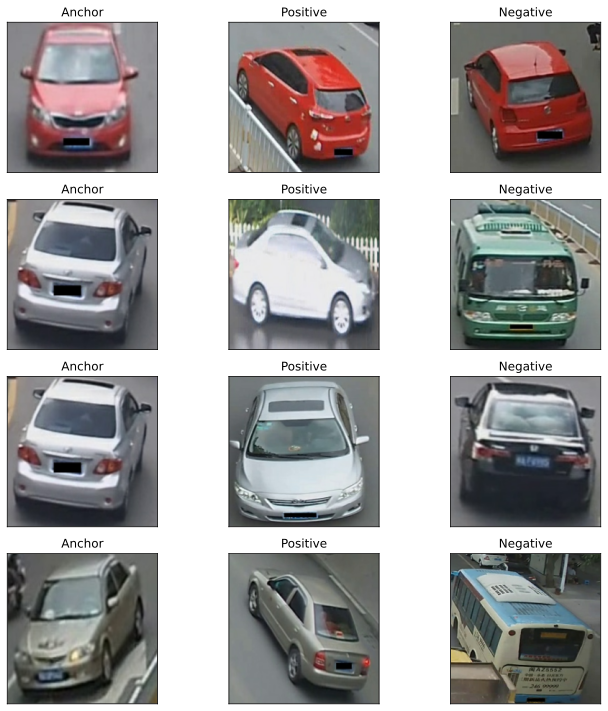

In [ ]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# Setting up the embedding generator model

Our Siamese Network will generate embeddings for each of the images of the
triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and
connect a few `Dense` layers to it so we can learn to separate these
embeddings.

Firstly, we will freeze the weights of all the layers of the model up until the layer `conv5_block1_out`. Firstly, not freeze any layer.
This is important to avoid affecting the weights that the model has already learned.
We are going to leave the bottom few layers trainable, so that we can fine-tune their weights during training.

In [ ]:
def freeze_weights(model, some=True, start=None):
    """
    Freezes all the weights of a given neural network or just freezes some of them
    """
    if some:
        assert start is not None

    else:
        trainable = True
        for layer in model.layers:
            layer.trainable = trainable

    #return model

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = Flatten()(base_cnn.output)
dense1 = Dense(512, activation="relu")(flatten)
dense1 = BatchNormalization()(dense1)
dense2 = Dense(256, activation="relu")(dense1)
dense2 = BatchNormalization()(dense2)
output = Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == 'conv4_block1_out': # 'conv5_block1_out':
        trainable = True
    layer.trainable = trainable

# Total params: 23587712 (89.98 MB)
# Trainable params: 20569600 (78.47 MB)
# Non-trainable params: 3018112 (11.51 MB)

94765736/94765736 [==============================] - 0s 0us/step


# Setting up the Siamese Network model

The Siamese network will receive each of the triplet images as an input,
generate the embeddings, and output the distance between the anchor and the
positive embedding, as well as the distance between the anchor and the negative
embedding.

To compute the distance, we can use a custom layer `DistanceLayer` that
returns both values as a tuple.

In [ ]:
class DistanceLayer(Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [ ]:
anchor_input = Input(name="anchor", shape=target_shape + (3,))
positive_input = Input(name="positive", shape=target_shape + (3,))
negative_input = Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

# Putting everything together

We now need to implement a model with custom training loop so we can compute
the triplet loss using the three embeddings produced by the Siamese network.

Let's create a `Mean` metric instance to track the loss of the training process.

In [ ]:
class SiameseModel(Model):
    """
    The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5, loss_tracker=None):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss") if loss_tracker is None else loss_tracker

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # Computing the loss so we can get the gradients and apply them using the optimizer
        # specified in `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Updating and returning the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Updating and returning the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value (max).
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # Listing our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


# Training

We are now ready to train our model.

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), weighted_metrics=[])
history = siamese_model.fit(
    train_dataset,
    epochs=6,
    validation_data=val_dataset
)

Epoch 1/6
934/934 [==============================] - 695s 699ms/step - loss: 0.2234 - val_loss: 0.2604
Epoch 2/6
934/934 [==============================] - 625s 670ms/step - loss: 0.1596 - val_loss: 0.2500
Epoch 3/6
934/934 [==============================] - 623s 667ms/step - loss: 0.1693 - val_loss: 0.2117
Epoch 4/6
934/934 [==============================] - 639s 684ms/step - loss: 0.1284 - val_loss: 0.1876
Epoch 5/6
934/934 [==============================] - 622s 666ms/step - loss: 0.1024 - val_loss: 0.1764
Epoch 6/6
934/934 [==============================] - 623s 667ms/step - loss: 0.0872 - val_loss: 0.1704


## Saving the model

In [ ]:
print(f"[INFO] saving the siamese network and the embedding model ...")
embedding.save(embedding_model_path)
keras.models.save_model(
	model=siamese_model.siamese_network,
	filepath=siamese_model_path,
	include_optimizer=False,
)

In [ ]:
def plot_history(training_history):
    """
    Plots the training and validation losses history.
    """
    metric:str = 'loss'
    val_metric:str = 'val_loss'
    train_values = training_history.history[metric]
    validation_values = training_history.history[val_metric]
    epochs = range(1, len(train_values) + 1)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(epochs, validation_values, '-+', label='Validation Loss')
    ax.plot(epochs, train_values, '-4', label='Training Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()

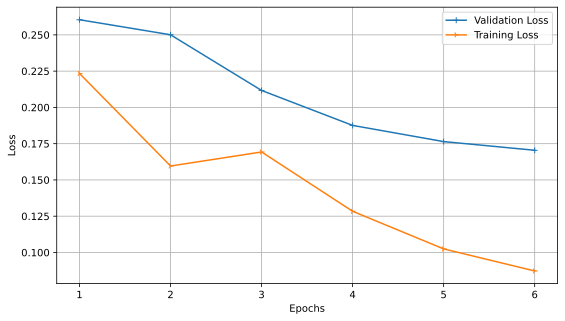

In [ ]:
plot_history(history)

## Loading the model

In [ ]:
print(f"[INFO] loading the siamese network ...")
siameseNetwork = keras.models.load_model(
    filepath=siamese_model_path
)

siamese_model = SiameseModel(
	siamese_network=siameseNetwork,
	margin=0.5,
	loss_tracker=metrics.Mean(name="loss"),
)

embedding = keras.models.load_model(
    filepath=embedding_model_path
)


# Functions to measure top-n accuracy and show top n retrievals

In [ ]:
def get_top_n_accuracy(query_images, embeddings, retrieval_images_paths, resnet_preprocess, n=1, log=False):
    """
    Computes the top-n accuracy of the model on the query_images .
    """
    counter = 0
    for query_image in query_images:
        query_image_label = query_image.split('/')[-1].split('_')[0]
        img, retrieved_imgs = make_image_retrieval(
            embeddings=embeddings,
            query_img_path=query_image,
            resnet_preprocess=resnet_preprocess,
            retrieval_images_paths=retrieval_images_paths,
            log=False,
            n=n,
        )
        retrieved_labels = [retrieved_img.split('/')[-1].split('_')[0] for retrieved_img in retrieved_imgs]
        if query_image_label in retrieved_labels:
            counter = counter + 1

        if log:
          print(query_image_label, retrieved_labels)

    return counter/len(query_images)

In [ ]:
def show_top_n_retrievals(query_img_path, retrived_images_paths, n):
    """
    Shows the top n retrievals aside to the query image.
    """

    assert n <= len(retrived_images_paths)
    fig, axs = plt.subplots(nrows=1, ncols=n+1, figsize=(12, 5))
    query_img_arr = preprocess_image(query_img_path)
    axs[0].imshow(query_img_arr)
    axs[0].set_title("Query image")
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)

    for i in range(n):
        img_arr = preprocess_image(retrived_images_paths[i])
        axs[i+1].imshow(img_arr)
        axs[i+1].set_title(f"Retrieval {i + 1}")
        axs[i+1].get_xaxis().set_visible(False)
        axs[i+1].get_yaxis().set_visible(False)

    fig.tight_layout()

# Computing the embeddings, making images retrieval and Calculating top-n accuracy

In [ ]:
def compute_embedding(img_path, resnet_preprocess):
    """
    Computes the and returns the embedding of a given image.
    """

    img_input = preprocess_image(img_path)
    if resnet_preprocess:
        img_input = resnet.preprocess_input(img_input)

    return embedding(np.expand_dims(img_input, axis=0))

In [ ]:
def get_top_rankings(query_img_path, saved_embeddings, resnet_preprocess, n=5):
    """
    Gets the top n rankings for a given query image.
    Returns the indexes of the similar images.
    """

    query_img_embedding = compute_embedding(
        img_path=query_img_path,
        resnet_preprocess=resnet_preprocess
    ).numpy()
    distances = np.array([np.linalg.norm(query_img_embedding - dataset_img) for dataset_img in saved_embeddings])
    return np.argsort(distances)[:n]

In [ ]:
def make_image_retrieval(embeddings, retrieval_images_paths, resnet_preprocess, n=5, query_images=None, query_img_path=None, log=True):
    """
    Retrieves the top n simalar images to the query image and returns their paths.
    """

    if query_img_path is None:
        assert query_images is not None
        query_img_path = random.choice(query_images)

    similar_image_indexes = get_top_rankings(
        query_img_path,
        saved_embeddings=embeddings,
        resnet_preprocess=resnet_preprocess,
        n=n,
    )

    if isinstance(retrieval_images_paths, pd.DataFrame):
        similar_image_paths = [retrieval_images_paths.loc[index]['image'] for index in similar_image_indexes]
    else:
        similar_image_paths = [retrieval_images_paths[index] for index in similar_image_indexes]

    if log:
        print(query_img_path)
        print(similar_image_paths)

    return query_img_path, similar_image_paths

## Using the training + validation sets images as retrieval images sets.

To test the model, we searched the images that are in the `training` and that were not used to train the model.
We used those images as query images and the images that the model trained on as retrieval images.

In [ ]:
def get_training_dataset_embeddings(indexes, resnet_preprocess):
    """
    Computes the embeddings of all the images in the training + validation sets.
    """

    embeddings = np.zeros((len(indexes), 1, 256))
    for index in tqdm.trange(len(indexes)):
        img_path = indexes[index]
        embed = compute_embedding(img_path, resnet_preprocess=resnet_preprocess)
        embeddings[index, :, :] = embed.numpy()

    return embeddings

In [ ]:
def get_query_images(indexes, dataset):
    """
    Finds and returns all the images that are in the training folder and that were not used to train the model.
    """

    processed_labels = []
    query_images = []
    for img in indexes.values():
        current_label = img.split('/')[-1].split('_')[0]
        if current_label not in processed_labels:
            processed_labels.append(current_label)
            label_images = dataset[dataset['label'] == current_label].image.values
            free_images = [img_path for img_path in label_images if img_path not in dataset_indexes]
            query_images.extend(free_images)

    return query_images

In [ ]:
# Calaculating the embeddings of all the images in the training + validation sets
training_dataset_embeddings = get_training_dataset_embeddings(dataset_indexes, resnet_preprocess=False)

100%|██████████| 21275/21275 [37:10<00:00,  9.54it/s]


In [ ]:
# Fetching all the possible query images
query_images_in_training_set = get_query_images(dataset_indexes, data)
print(f"Found {len(query_images_in_training_set)} query images")

Found 23832 query images


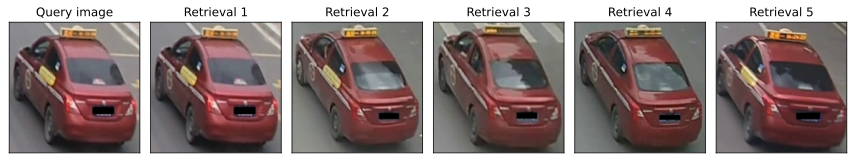

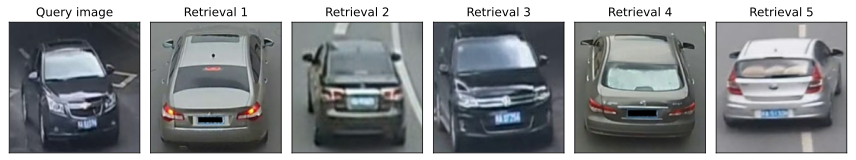

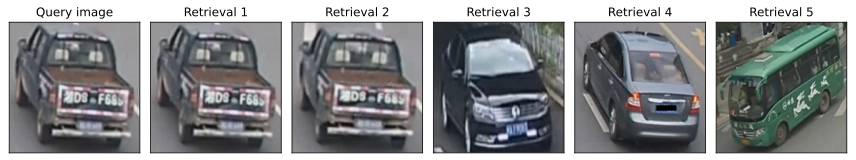

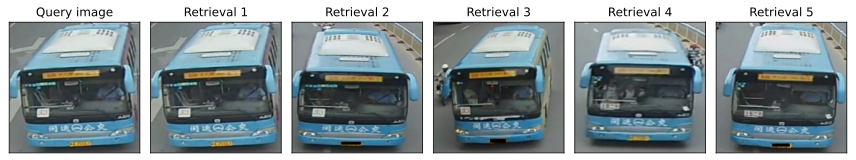

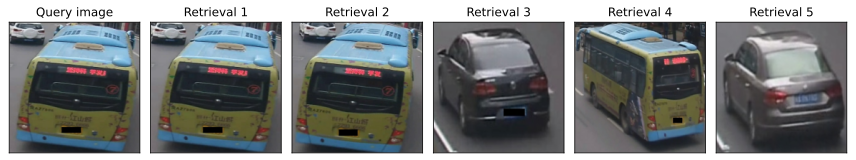

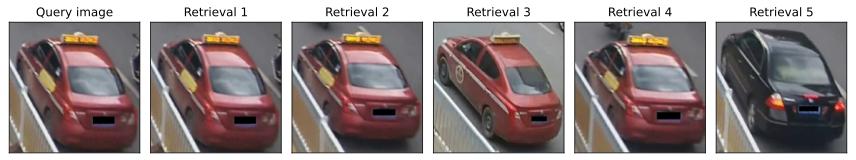

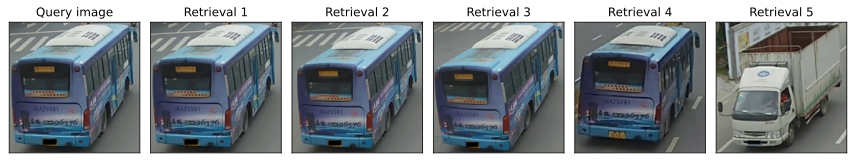

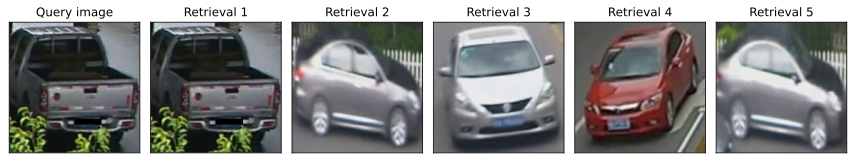

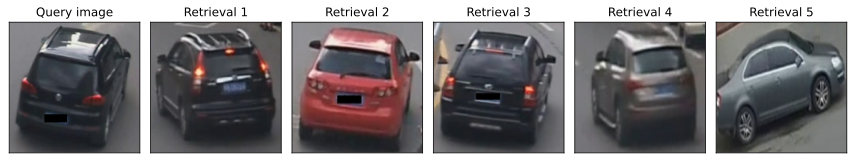

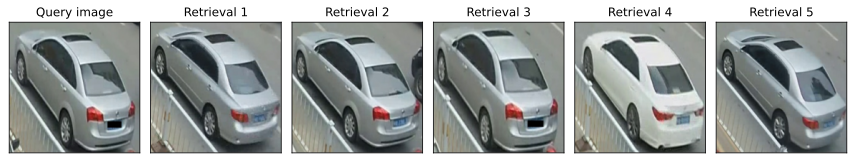

In [ ]:
for i in range(10):
    # Making a retrieval from a random image
    query_img, retrieved_imgs = make_image_retrieval(
        embeddings=training_dataset_embeddings,
        query_images=query_images_in_training_set,
        retrieval_images_paths=dataset_indexes,
        resnet_preprocess=False,
        n=5,
        log=False,
    )

    # Showing the query and the retrieved images
    show_top_n_retrievals(query_img, retrieved_imgs, n=5)

In [ ]:
# Computing the top-n accuracies
top_1_acc = get_top_n_accuracy(
    query_images=query_images_in_training_set[:200],
    embeddings=training_dataset_embeddings,
    retrieval_images_paths=dataset_indexes,
    resnet_preprocess=False,
    n=1,
)
print(f"Top-1 Accuracy : {top_1_acc*100:.2f}%")

top_5_acc = get_top_n_accuracy(
    query_images=query_images_in_training_set[:200],
    embeddings=training_dataset_embeddings,
    retrieval_images_paths=dataset_indexes,
     resnet_preprocess=False,
    n=5
)
print(f"Top-5 Accuracy : {top_5_acc*100:.2f}%")

Top-1 Accuracy : 100.00%
Top-5 Accuracy : 100.00%


## Using the testing set images as retrieval images sets.

To test the model, we loaded the images in the query folder and used them as query images. The retrieval images used are those in the test folder.

In [ ]:
def get_testing_dataset_embeddings(test_df, resnet_preprocess):
    """
    Computes the embeddings of all the images in the testing set.
    """

    embeddings = np.zeros((len(test_df), 1, 256))
    for index in tqdm.trange(len(test_df)):
        img_path = test_df.loc[index]['image']
        embed = compute_embedding(img_path, resnet_preprocess=resnet_preprocess)
        embeddings[index, :, :] = embed.numpy()

    return embeddings

In [ ]:
# Loading the tests and query images
test_images_minibatch = get_minibatch(data, "test", 200, 4) #50
query_images_minibatch = get_minibatch(data, "query", 200, 3)

In [ ]:
# Computing the testing images embeddings
testing_dataset_embeddings = get_testing_dataset_embeddings(test_images_minibatch, resnet_preprocess=False)

100%|██████████| 800/800 [01:25<00:00,  9.32it/s]


In [ ]:
# Converting the query images to a list of str (paths to the images)
query_images_in_query_set = query_images_minibatch['image'].values
print(f"Found {len(query_images_in_query_set)} query images")

Found 598 query images


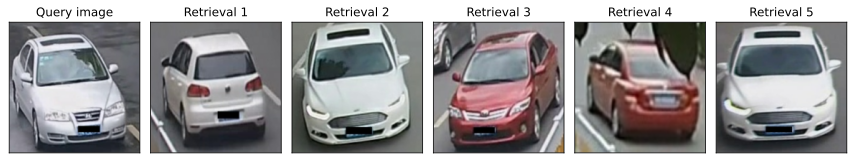

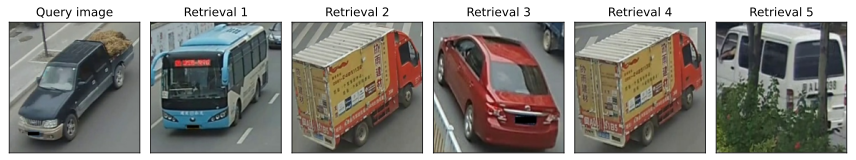

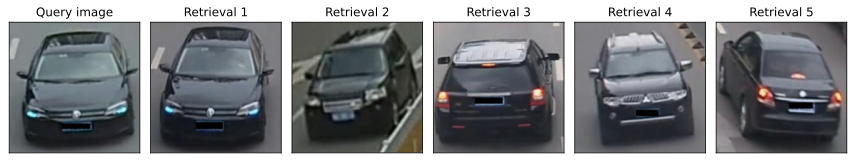

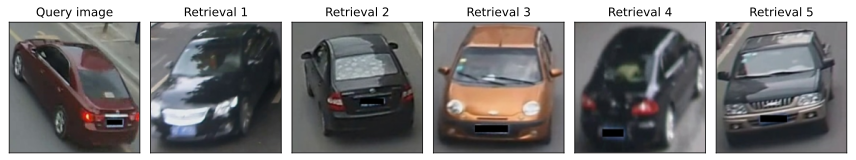

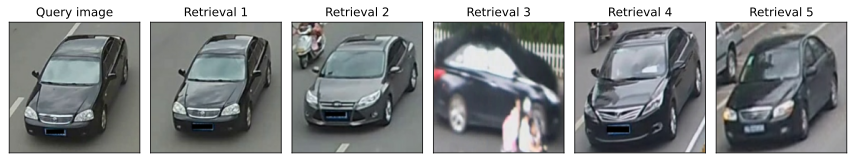

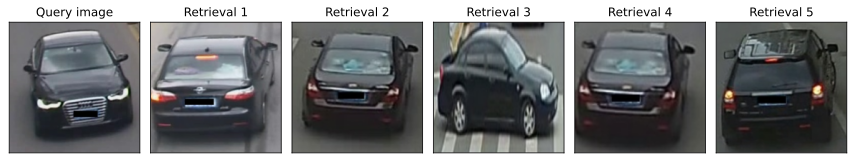

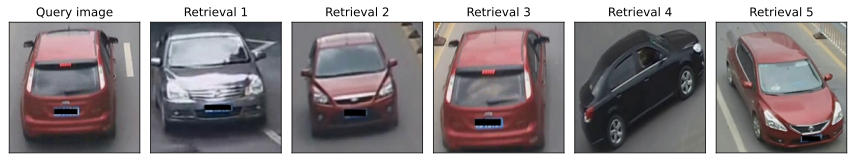

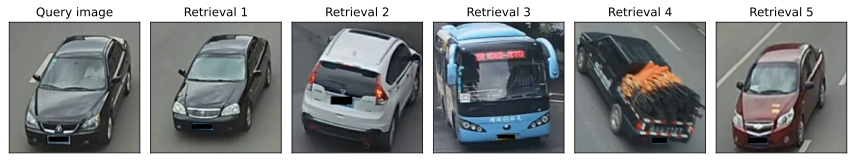

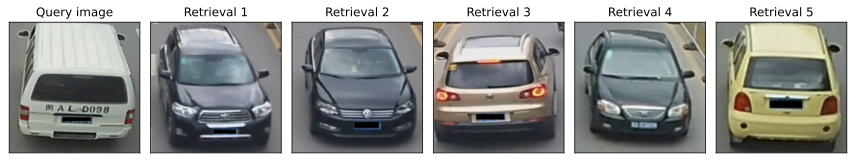

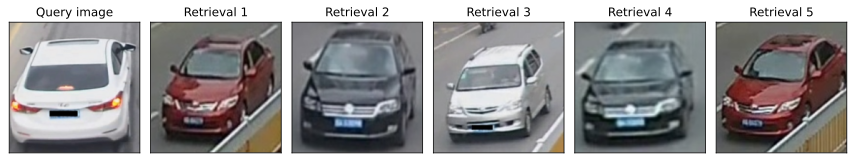

In [ ]:
for i in range(10):
    # Making a retrieval from a random image
    query_img, retrieved_imgs = make_image_retrieval(
        embeddings=testing_dataset_embeddings,
        query_images=query_images_in_query_set,
        retrieval_images_paths=test_images_minibatch,
        resnet_preprocess=False,
        n=5,
        log=False,
    )

    # Showing the query and the retrieved images
    show_top_n_retrievals(query_img, retrieved_imgs, n=5)

In [ ]:
# Computing the top-n accuracies
top_1_acc = get_top_n_accuracy(
    query_images=query_images_in_query_set[:300],
    embeddings=testing_dataset_embeddings,
    retrieval_images_paths=test_images_minibatch,
    resnet_preprocess=False,
    n=1,
)
print(f"Top-1 Accuracy : {top_1_acc*100:.2f}%")

top_5_acc = get_top_n_accuracy(
    query_images=query_images_in_query_set[:300],
    embeddings=testing_dataset_embeddings,
    retrieval_images_paths=test_images_minibatch,
    resnet_preprocess=False,
    n=5
)
print(f"Top-5 Accuracy : {top_5_acc*100:.2f}%")

Top-1 Accuracy : 15.67%
Top-5 Accuracy : 25.33%


# Discussion

The model got Top-1 Accuracy : 100.00% and Top-5 Accuracy : 100.00% when we used as retrieval images the training dataset images but got Top-1 Accuracy : 15.67% and Top-5 Accuracy : 25.33% when we used completly new images from the test set as retrieval images.

The difference in the two results can be explained by the fact that the model is not able to generalize. The model might be overfitting the training data.

Another possibility is **Hard triplets** in our training dataset where the negative sample representation is close to the anchor sample representation than the positive. This makes the model correctly distinguish between the positive and negative samples of those triplet. This can stall training.

In [ ]:
%%shell
jupyter nbconvert --to html /content/aurel_CV_assignment_03.ipynb

[NbConvertApp] Converting notebook /content/aurel_CV_assignment_03.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 280, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconverta

CalledProcessError: ignored